# Exploratory Data Analysis

This notebook explores relationships between objective function paramameters, dose statistics, and clinical goals.
I randomly sampled 100 treatment plans by changing the DoseValue parameter for five OARs:
* SpinalCanal
* Heart
* Rib
* Chestwall_L
* Lungs

I recorded DoseValue parameters used, dose statistics, and clinical goal values for each plan and each ROI (including the PTV).
My main goal was to see if there are any clear correlations between the different ROIs.
I'm also interested in looking into how we can design a better kernel for the Gaussian processes used in our Bayesian optimization.

### Objective function terms

Objective function terms can be accessed with the following code:
```python
import connect
plan = connect.get_current('Plan')
funcs = plan.PlanOptimizations[0].Objective.ConstituentFunctions
```

Relevant values for the ``ii``th term can be found here:
```python
funcs[ii].ForRegionOfInterest.Name
funcs[ii].DoseFunctionParameters.FunctionType
funcs[ii].DoseFunctionParameters.DoseLevel
funcs[ii].DoseFunctionParameters.PercentVolume
funcs[ii].DoseFunctionParameters.Weight
```

The following are the parameters used for the approved plan:

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | SpinalCanal | Max Dose 2080 cGy | MaxDose | 2080 | 95 | 90
2 | Heart | Max Dose 2800 cGy | MaxDose | 2800 | 95 | 90
6 | Rib | Max Dose 3200 cGy | MaxDose | 3200 | 95 | 90
8 | PTV | Max Dose 6240 cGy | MaxDose | 6240 | 0 | 95
9 | PTV | Min Dose 4800 cGy | MinDose | 4800 | 0 | 100
10 | Chestwall_L | Max DVH 3000 cGy to 1.5% volume | MaxDvh | 3000 | 1.5 | 90
11 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 90

### Dose Statistics

Dose statistics can be accessed with the following code:
```python
dose = plan.TreatmentCourse.TotalDose
dose.GetDoseStatistic(RoiName=roi, DoseType='Min')
dose.GetDoseStatistic(RoiName=roi, DoseType='Average')
dose.GetDoseStatistic(RoiName=roi, DoseType='Max')
dose.GetDoseAtRelativeVolumes(RoiName=roi, RelativeVolumes=[0.99, 0.98, ...])
dose.GetRelativeVolumeAtDose(RoiName=roi, DoseValues=np.linspace(0, max_dose, 100))
```

### Clinical goals

Clinical goals can be accessed with the following code:
```python
goals = plan.TreatmentCourse.EvaluationSetup.EvaluationFunctions
```

Relevant values for the ``ii``th term can be found here:
```python
goals[ii].ForRegionOfInterest.Name
goals[ii].PlanningGoal.Type
goals[ii].PlanningGoal.GoalCriteria
goals[ii].PlanningGoal.AcceptanceLevel
goals[ii].PlanningGoal.ParameterValue
goals[ii].GetClinicalGoalValue()
```

The following goals are used for the approved plan:

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
2 | Heart | At most 3400 cGy dose at 0 cm$^3$ volume | DoseAtAbsoluteVolume | AtMost | 3400 | 0
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
8 | Lungs | At most 1500 cm$^3$ volume at 1160 cGy dose | AbsoluteVolumeAtDose| AtMost | 1500 | 1160
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200
15 | Rib | At most 4000 cGy dose at 0.04 cm$^3$ volume | DoseAtAbsoluteVolume | AtMost | 4000 | 0.035
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320

### Results Format

My script samples.py saves results as a list, where each list element corresponds to one sampled treatment plan. Each treatment plan contains the following three dictionaries:

Dose Parameters
```python
{ Name : [{'idx', 'DoseLevel', 'Range'}] }
```

Dose Statistics
```python
{ Name : {'Min', 'Max', 'Average', 'D99', 'D98', 'D95', 'D50', 'D5', 'D2','D1'} }
```

Clinical Goals
```python
{ Name : [{ 'idx', 'GoalCriteria', 'AcceptanceLevel', 'GoalValue' }] }
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

samples = np.load('samples_6_5.npy', allow_pickle=True)

# Dose parameters

In [2]:
def roi_pars(samples, roi):
    """Create list of sampled ROI DoseLevel parameters."""
    par_list = []
    for ii in range(len(samples[0][0][roi])):
        par_list.append([samples[jj][0][roi][ii]['DoseLevel'] for jj in range(len(samples))])
    return par_list

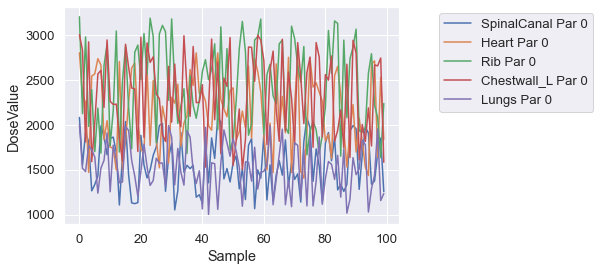

In [3]:
# Plot sampled DoseLevels
oar_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs']
labels = []
for oar in oar_list:
    par_list = roi_pars(samples, oar)
    for ii in range(len(par_list)):
        plt.plot(par_list[ii])
        labels.append(f'{oar} Par {ii}')
plt.xlabel('Sample')
plt.ylabel('DoseValue')
plt.legend(labels=labels, bbox_to_anchor=(1.1, 1));

# Dose Statistics

In [4]:
def roi_stats(samples, roi, stat_type):
    """Get list of sampled ROI statistics."""
    return [samples[ii][1][roi][stat_type] for ii in range(len(samples))]

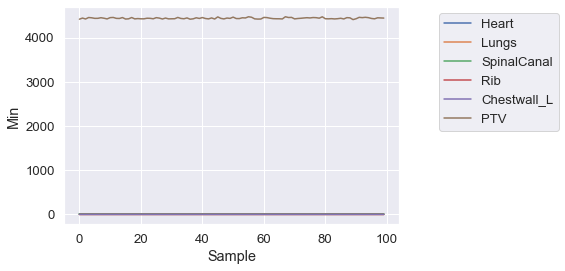

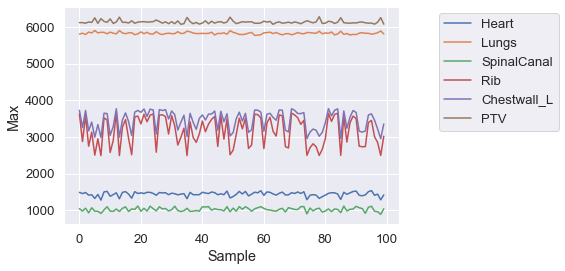

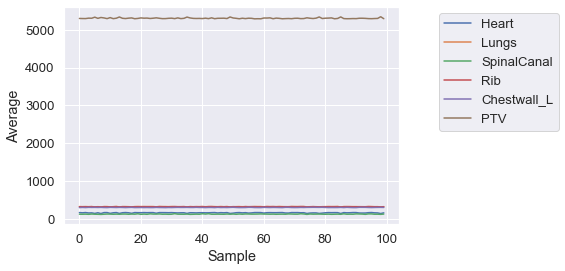

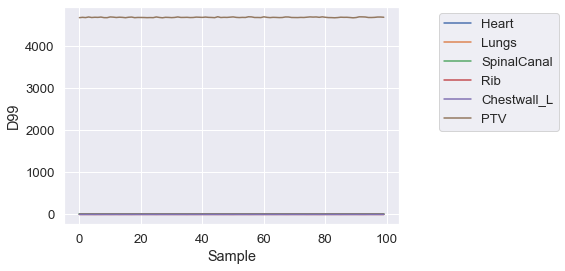

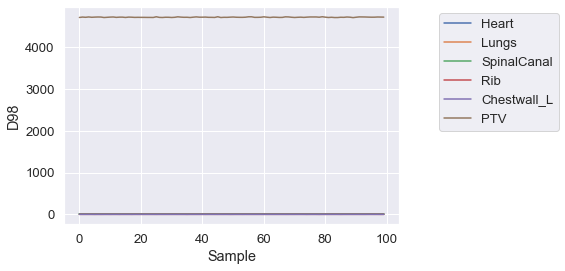

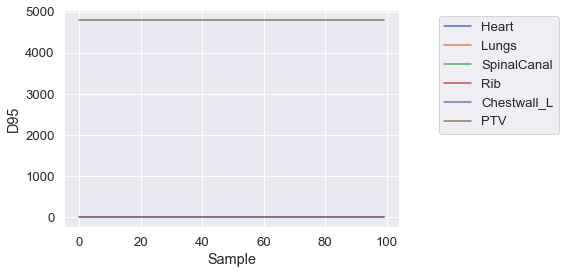

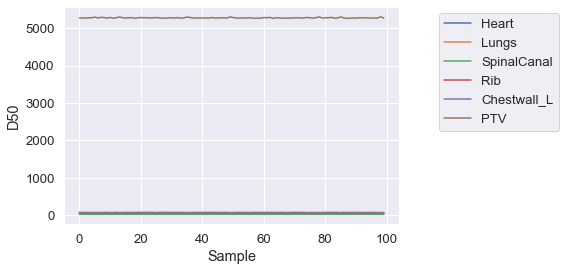

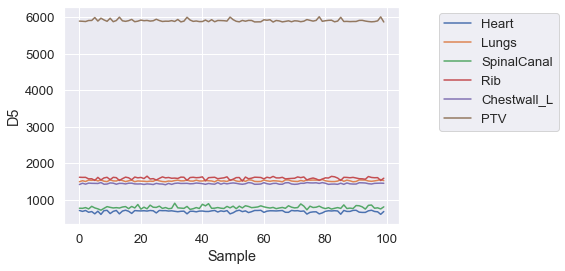

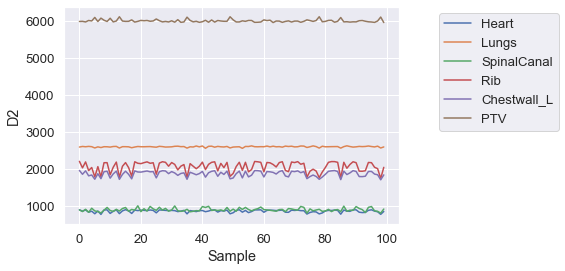

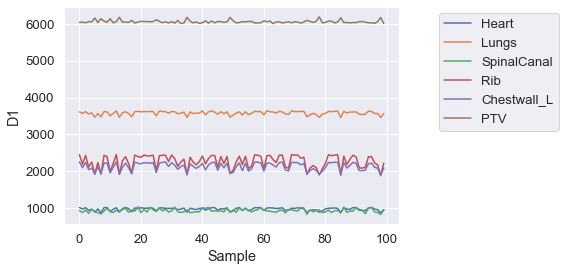

In [5]:
# Plot each statistics for all ROIs
roi_list = ['Heart', 'Lungs', 'SpinalCanal', 'Rib', 'Chestwall_L', 'PTV']
for stat in samples[0][1]['Heart'].keys():
    plt.figure()
    for roi in roi_list:
        plt.plot(roi_stats(samples, roi, stat))
    plt.xlabel('Sample')
    plt.ylabel(stat)
    plt.legend(labels=roi_list, bbox_to_anchor=(1.1, 1))

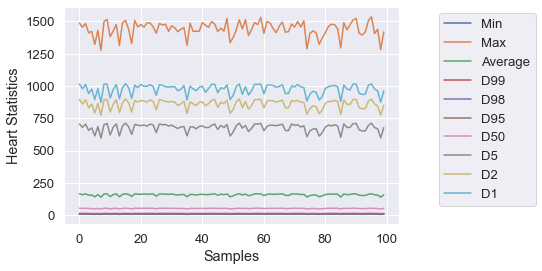

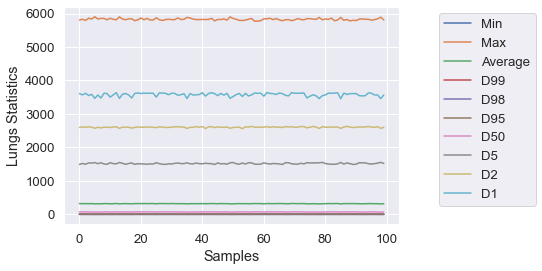

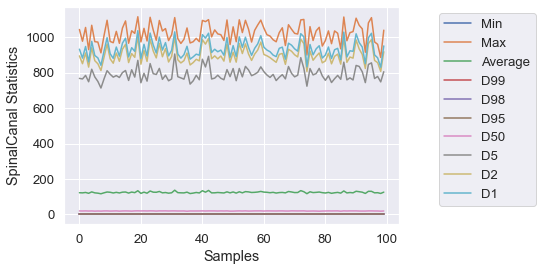

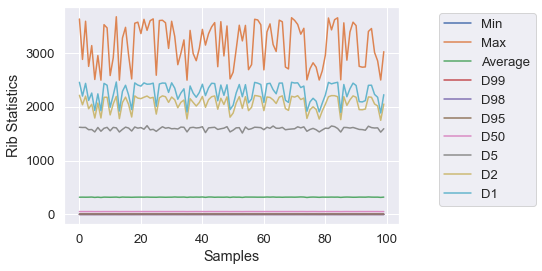

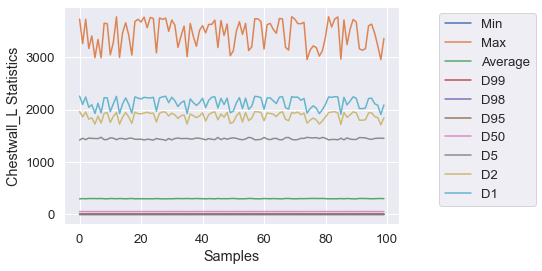

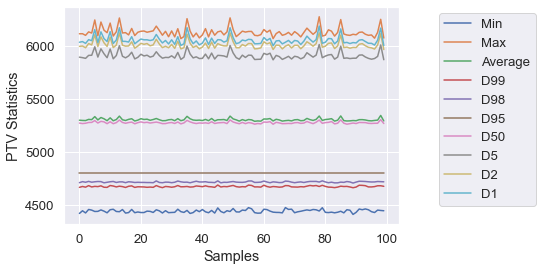

In [6]:
# Plot all statistics for each ROI
for roi in roi_list:
    plt.figure()
    labels = []
    for stat in samples[0][1][roi].keys():
        plt.plot(roi_stats(samples, roi, stat))
        labels.append(stat)
    plt.xlabel('Samples')
    plt.ylabel(f'{roi} Statistics')
    plt.legend(labels=labels, bbox_to_anchor=(1.1, 1))

# Clinical Goals

In [7]:
def roi_goals(samples, roi):
    """Get list of sampled ROI clinical goal results."""
    goal_list = []
    for ii in range(len(samples[0][2][roi])):
        goal_list.append([goal_percent(samples[jj][2][roi][ii]) for jj in range(len(samples))])
    return goal_list

def goal_percent(goal):
    """Calculate percent change from clinical goal."""
    return (-1)**(goal['GoalCriteria'] == 'AtMost')*(goal['AcceptanceLevel'] - goal['GoalValue'])/goal['AcceptanceLevel']

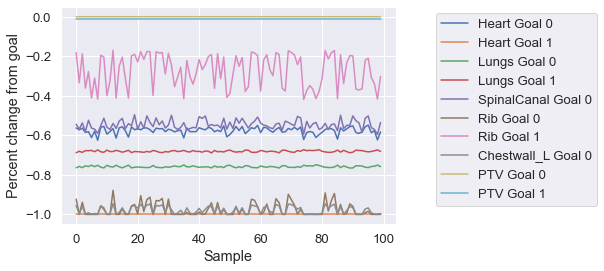

In [8]:
# Plot percent difference from clinical goal
roi_list = ['Heart', 'Lungs', 'SpinalCanal', 'Rib', 'Chestwall_L', 'PTV']
labels = []
for roi in roi_list:
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        plt.plot(goal_list[ii])
        labels.append(f'{roi} Goal {ii}')
plt.xlabel('Sample')
plt.ylabel('Percent change from goal')
plt.legend(labels=labels, bbox_to_anchor=(1.1, 1));

# Since the PTV doesn't have a goal based on the maximum value, 
# scoring plans based only on clinical goals will not be able to 
# limit the maximum dose!

# Covariance and Correlation within Statistics

In [9]:
# Modified from https://github.com/dylan-profiler/heatmaps
# * Added title to heatmap
# * Changed default size_scale
# * Created covariance heatmap

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale',
         'marker', 'x_order', 'y_order', 'xlabel', 'ylabel', 'title'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))
    ax.set_title(kwargs.get('title', ''))

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 
        
def corrplot(data, title, size_scale=100, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0, 1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale,
        title=title
    )
    
def covplot(data, title, size_scale=100, marker='s'):
    cov = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    cov.columns = ['x', 'y', 'value']
    max_val = max(abs((cov['value'])))
    heatmap(
        cov['x'], cov['y'], 
        color=cov['value'], color_range=[-max_val, max_val],
        palette=sns.diverging_palette(20, 220, n=256),
        size=cov['value'].abs(), size_range=[0, 1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale,
        title=title
    )

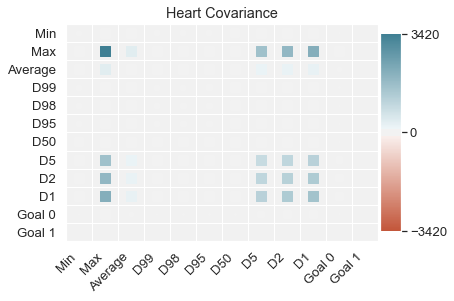

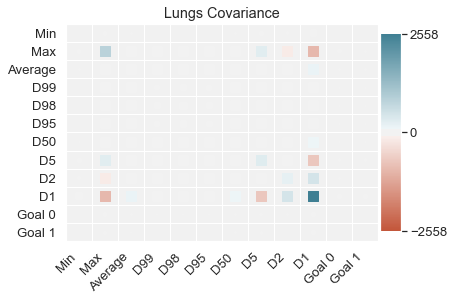

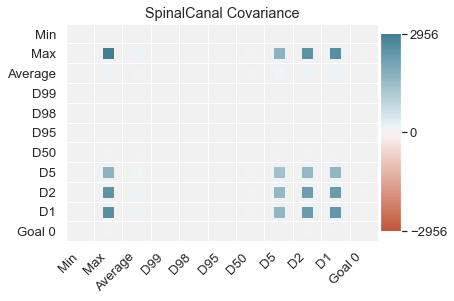

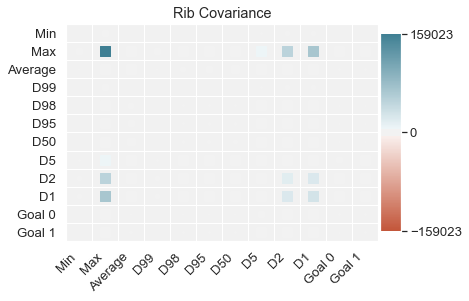

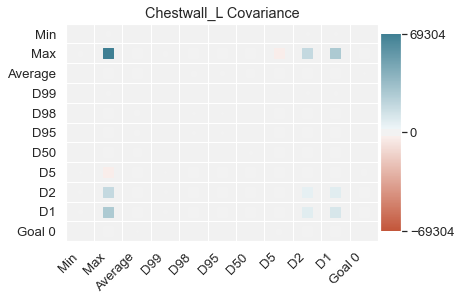

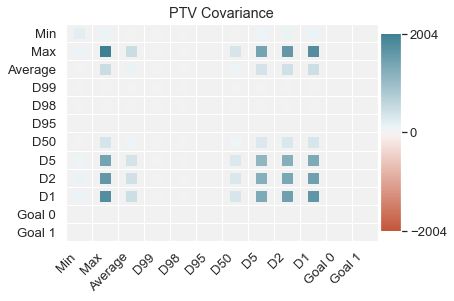

In [10]:
# Plot covariances
for roi in roi_list:
    roi_dict = {}
    for stat in samples[0][1][roi].keys():
        roi_dict[stat] = roi_stats(samples, roi, stat)
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        roi_dict[f'Goal {ii}'] = goal_list[ii]
    roi_df = pd.DataFrame(data=roi_dict) 
    plt.figure()
    covplot(data=roi_df.cov(), title=f'{roi} Covariance')

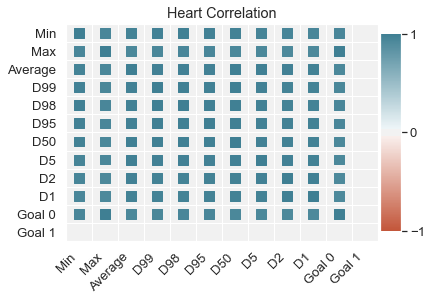

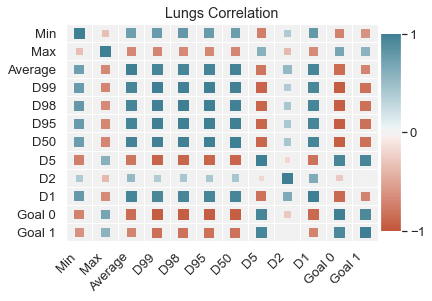

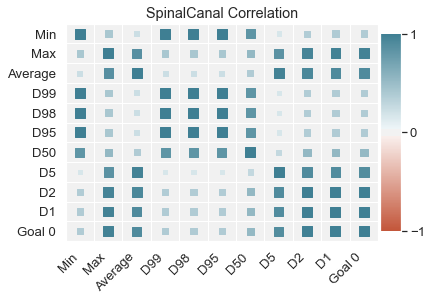

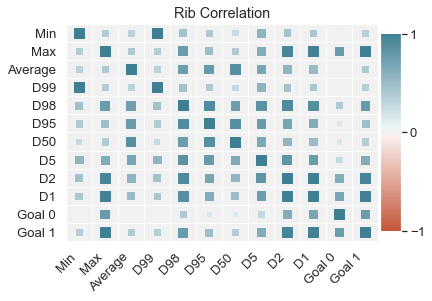

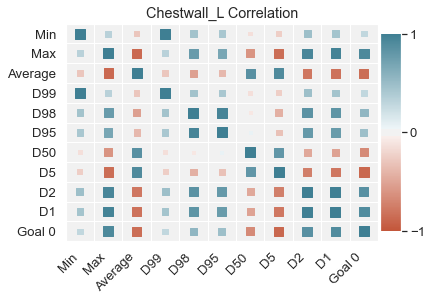

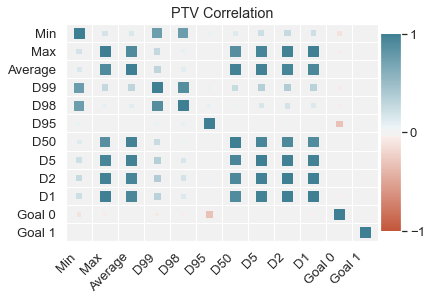

In [11]:
# Plot correlations
for roi in roi_list:
    roi_dict = {}
    for stat in samples[0][1][roi].keys():
        roi_dict[stat] = roi_stats(samples, roi, stat)
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        roi_dict[f'Goal {ii}'] = goal_list[ii]
    roi_df = pd.DataFrame(data=roi_dict) 
    plt.figure()
    corrplot(data=roi_df.corr(), title=f'{roi} Correlation')
    
# Note: Heart Goal 1 always had value -1, so no variance, so correlation was NaN

# Covariance and Correlation within ROIs

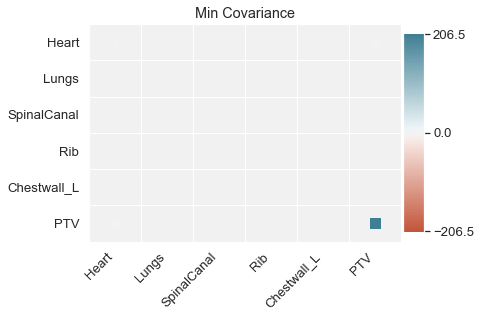

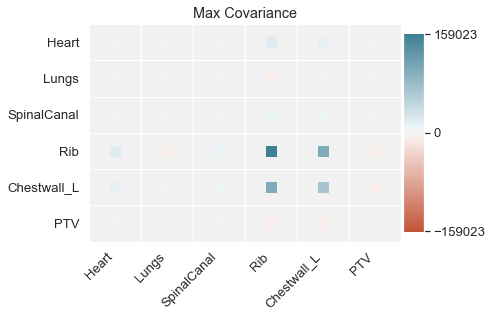

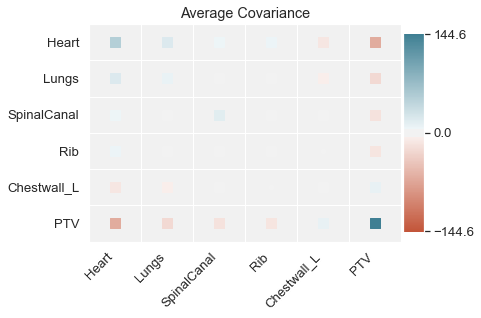

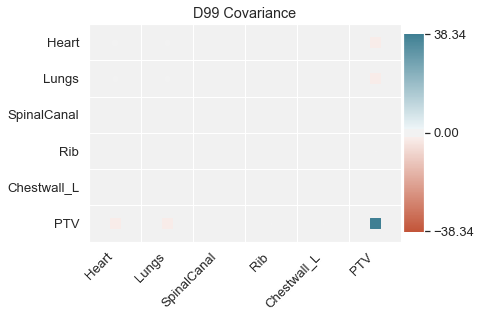

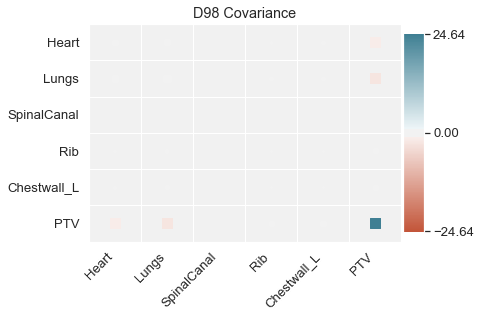

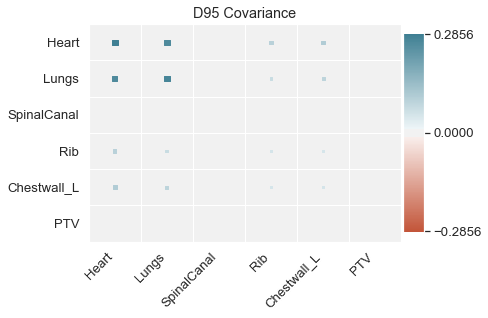

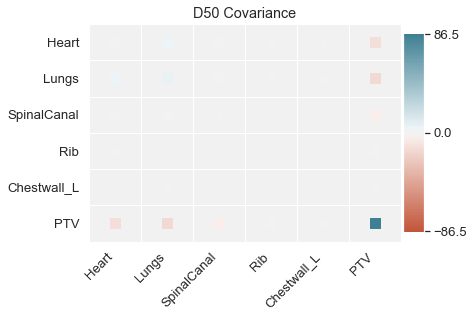

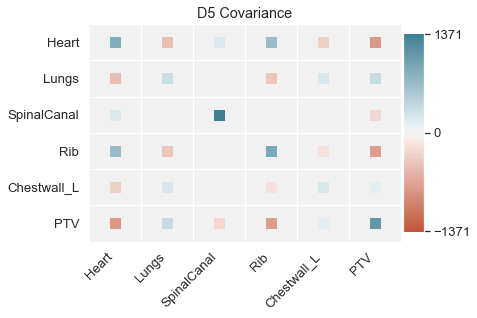

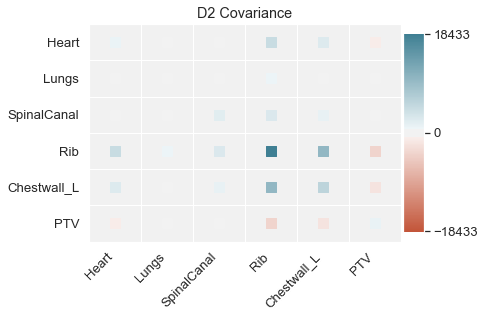

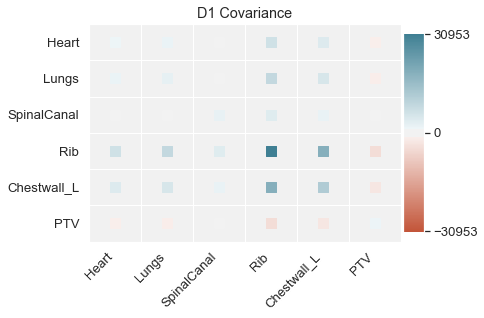

In [12]:
# Plot covariances
for stat in samples[0][1]['Heart'].keys():
    stat_dict = {}
    for roi in roi_list:
        stat_dict[roi] = roi_stats(samples, roi, stat)
    stat_df = pd.DataFrame(data=stat_dict)
    plt.figure()
    covplot(data=stat_df.cov(), title=f'{stat} Covariance')

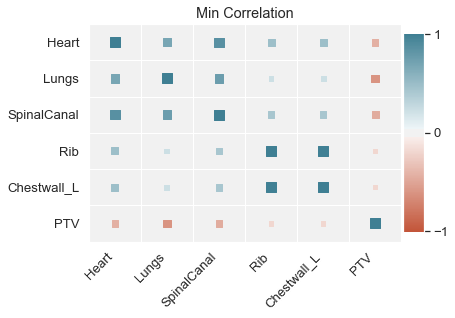

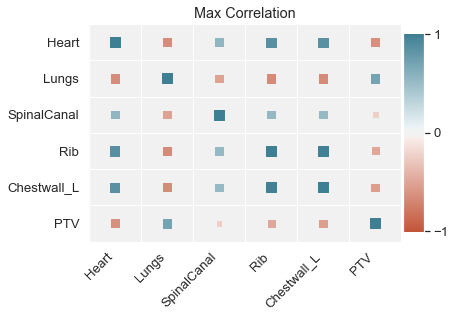

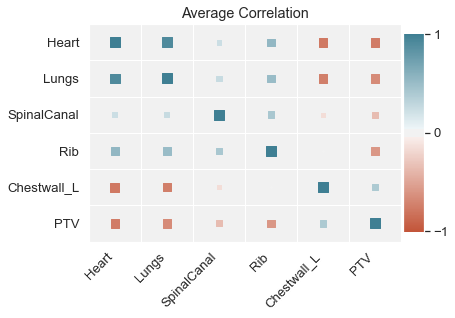

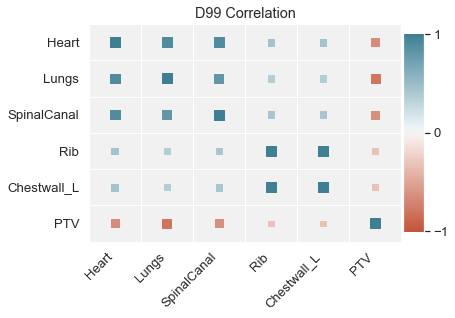

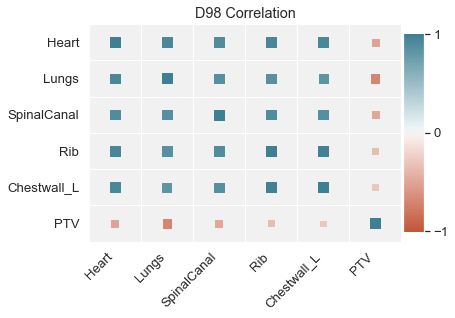

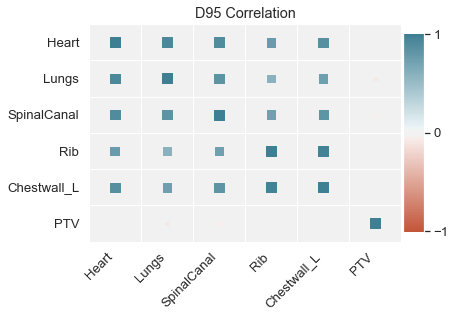

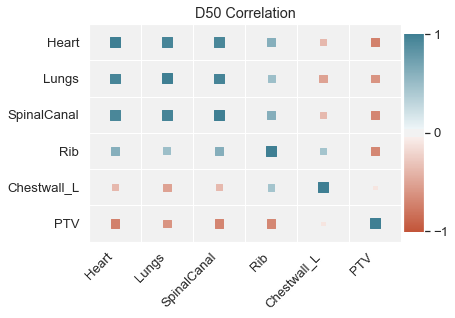

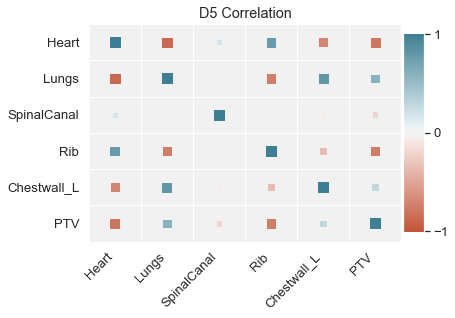

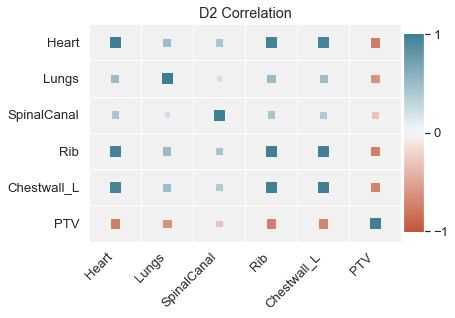

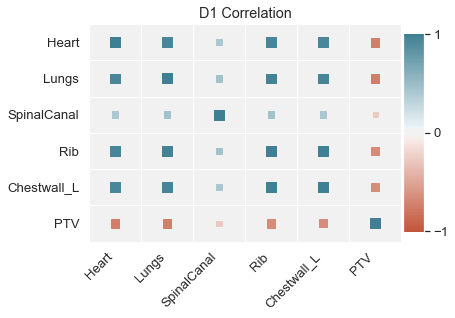

In [13]:
# Plot correlations
for stat in samples[0][1]['Heart'].keys():
    stat_dict = {}
    for roi in roi_list:
        stat_dict[roi] = roi_stats(samples, roi, stat)
    stat_df = pd.DataFrame(data=stat_dict)
    plt.figure()
    corrplot(data=stat_df.corr(), title=f'{stat} Correlation')

# Covariance and Correlation with Goals

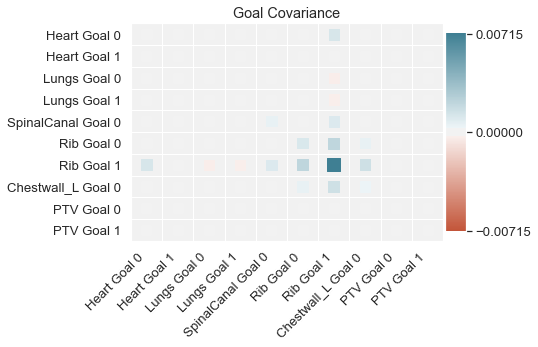

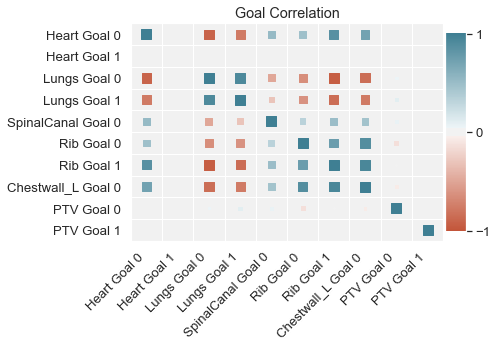

In [14]:
goal_dict = {}
for roi in roi_list:
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        goal_dict[f'{roi} Goal {ii}'] = goal_list[ii]
    goal_df = pd.DataFrame(data=goal_dict)
    
# Plot covariance
plt.figure()
covplot(data=goal_df.cov(), title='Goal Covariance', size_scale=1e4)

# Plot correlations
plt.figure()
corrplot(data=goal_df.corr(), title='Goal Correlation')

# Covariance between Parameters and Statistics

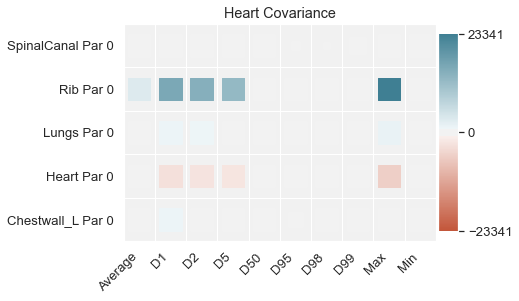

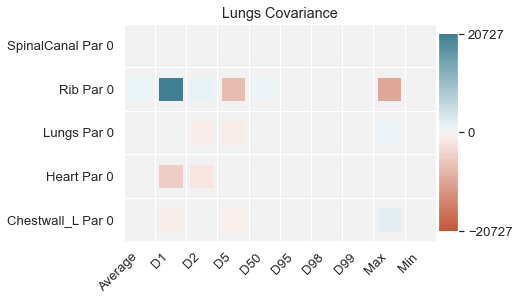

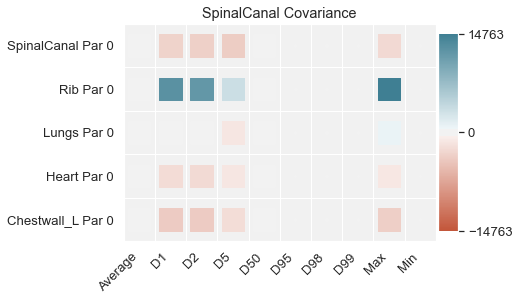

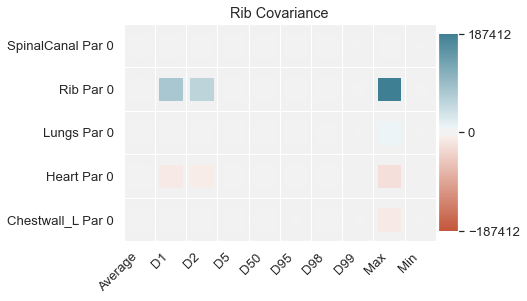

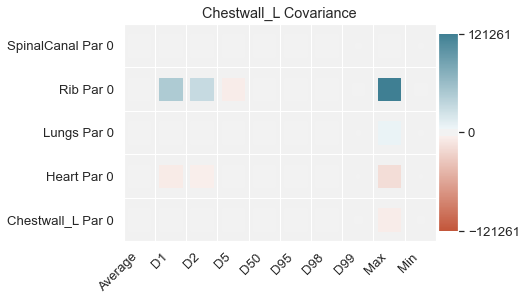

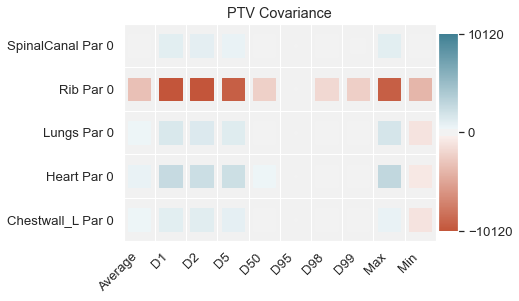

In [17]:
for roi in roi_list:
    # Add dose parameters
    res_dict = {}
    par_labels = []
    for oar in oar_list:
        par_list = roi_pars(samples, oar)
        for ii in range(len(par_list)):
            label = f'{oar} Par {ii}'
            par_labels.append(label)
            res_dict[label] = par_list[ii]
            
    # Add dose statistics
    stat_labels = []
    for stat in samples[0][1][roi].keys():
        stat_labels.append(stat)
        res_dict[stat] = roi_stats(samples, roi, stat)
    
    # Create DataFrame
    res_df = pd.DataFrame(data=res_dict)
    res_cov = res_df.cov()
    res_cov = res_cov[par_labels].loc[stat_labels]

    # Plot covariance
    plt.figure()
    cov = pd.melt(res_cov.reset_index(), id_vars='index').replace(np.nan, 0)
    cov.columns = ['x', 'y', 'value']
    max_val = max(abs((cov['value'])))
    heatmap(
        cov['x'], cov['y'], 
        color=cov['value'], color_range=[-max_val, max_val],
        palette=sns.diverging_palette(20, 220, n=256),
        size=cov['value'].abs(), size_range=[0, 1],
        title=f'{roi} Covariance'
    )

# Correlation between Parameters and Statistics

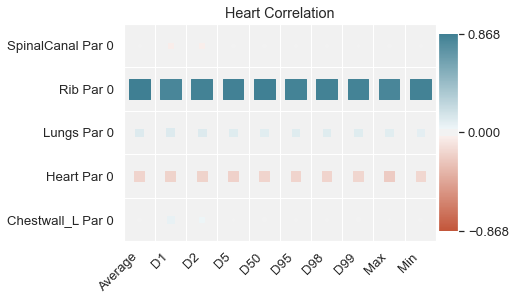

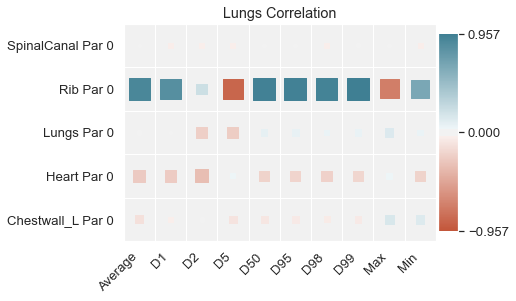

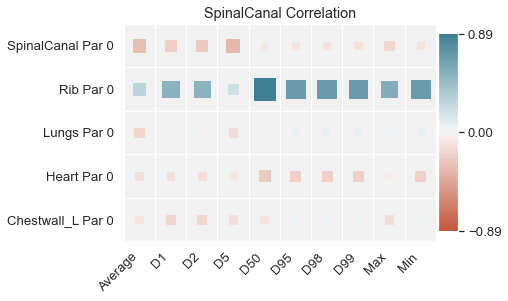

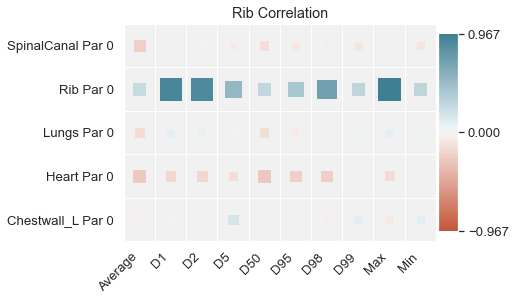

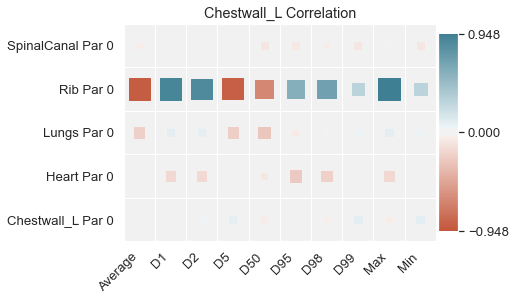

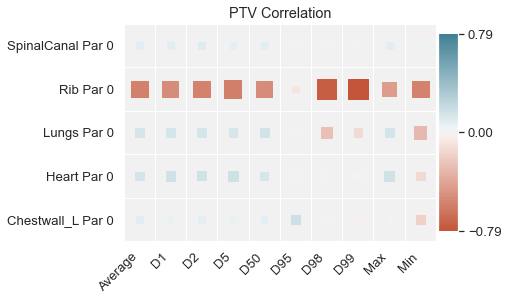

In [18]:
for roi in roi_list:
    # Add dose parameters
    res_dict = {}
    par_labels = []
    for oar in oar_list:
        par_list = roi_pars(samples, oar)
        for ii in range(len(par_list)):
            label = f'{oar} Par {ii}'
            par_labels.append(label)
            res_dict[label] = par_list[ii]
            
    # Add dose statistics
    stat_labels = []
    for stat in samples[0][1][roi].keys():
        stat_labels.append(stat)
        res_dict[stat] = roi_stats(samples, roi, stat)
    
    # Create DataFrame
    res_df = pd.DataFrame(data=res_dict)
    res_corr = res_df.corr()
    res_corr = res_corr[par_labels].loc[stat_labels]

    # Plot covariance
    plt.figure()
    corr = pd.melt(res_corr.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    max_val = max(abs((corr['value'])))
    heatmap(
        corr['x'], corr['y'], 
        color=corr['value'], color_range=[-max_val, max_val],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0, 1],
        title=f'{roi} Correlation'
    )

# Covariance and Correlation between Parameters and Goals

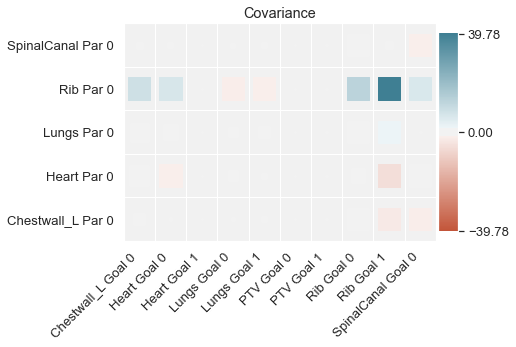

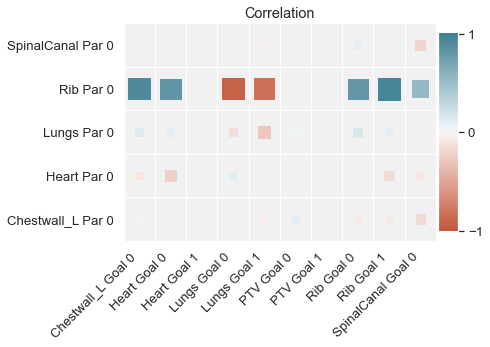

In [15]:
# Add dose parameters
res_dict = {}
par_labels = []
for oar in oar_list:
    par_list = roi_pars(samples, oar)
    for ii in range(len(par_list)):
        label = f'{oar} Par {ii}'
        par_labels.append(label)
        res_dict[label] = par_list[ii]

# Add goal values
goal_labels = []
for roi in roi_list:
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        label = f'{roi} Goal {ii}'
        goal_labels.append(label)
        res_dict[label] = goal_list[ii]

# Create DataFrame
res_df = pd.DataFrame(data=res_dict)
res_cov = res_df.cov()
res_cov = res_cov[par_labels].loc[goal_labels]
res_corr = res_df.corr()
res_corr = res_corr[par_labels].loc[goal_labels]

# Plot covariance
plt.figure()
cov = pd.melt(res_cov.reset_index(), id_vars='index').replace(np.nan, 0)
cov.columns = ['x', 'y', 'value']
max_val = max(abs((cov['value'])))
heatmap(
    cov['x'], cov['y'], 
    color=cov['value'], color_range=[-max_val, max_val],
    palette=sns.diverging_palette(20, 220, n=256),
    size=cov['value'].abs(), size_range=[0, 1],
    title='Covariance'
)

# Plot correlation
plt.figure()
corr = pd.melt(res_corr.reset_index(), id_vars='index').replace(np.nan, 0)
corr.columns = ['x', 'y', 'value']
heatmap(
    corr['x'], corr['y'], 
    color=corr['value'], color_range=[-1, 1],
    palette=sns.diverging_palette(20, 220, n=256),
    size=corr['value'].abs(), size_range=[0, 1],
    title='Correlation'
)